# Описание

В этом ноутбуке проводится эксперимент по распознаванию лиц на основе facenet-pytorch и метрики близости объектов (l2-distance).

Описание сети и метод распознавания приведены в статье - https://arxiv.org/pdf/1503.03832.pdf .

facenet-pytorch была натренирована на большом датасете с использование TripletLoss (предообученная модель в пакете facenet-pytorch). Такой подход позволяет обученной сети производить отображения исходных лиц в пространство, в котором отображения(эмбединги) одного лица находятся максимльно близко, и максимально далеко от эмбединогов других лиц. Таким образом, эмбединги одного лица должны представлять компактные кластеры. Принадлежность эмбединга к конкретному кластеру можно определить по значению метрики близости (например l2 distance): для эмбедингов одного лица l2 distance - мало, для эмбедингов разны лиц - велико. Таким образом, необходимо подобрать порог (treshold).

В ноутбуке использован dataset, состоящий из 40 изображений одного человека (класс - p) и 150 изображений других разных людей (множество - o). Также используется тестовая выборка p_test из 52 объектов (класс - P).

В ноутбуке реализованы следующие эксперименты:

1.Рассчитаны l2 между всеми изображениями из p, рассчитаны некоторые статистики

2. Рассчитан центр кластера p, рассчитаны l2 от центра до всех изображений из p, а также некоторые статистики

3. Расчитаны растояния от случайного объекта из p до объектов p_test, расчитано расстонятия от центра p до объектов p_test

4. Рассчитаны l2 внутри o и статистики

5. Рассчитаны l2 от случайного p до всех o

6. Рассчитаны l2 от центра p до всех o

# Подключим Gdrive

In [54]:
# First we need to mount the Google drive 
import os
from google.colab import drive
drive.mount('/content/gdrive')
# Here specify the path to your directory
root_path = '/content/gdrive/MyDrive/Colab Notebooks/faceDetection/' 
im_dir='data_faces/raw_images/'
os.chdir(root_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Импорт модулей

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import numpy as np
import os
from PIL import Image
from io import BytesIO
import re
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from IPython import display

# Вспомогательные функции

In [ ]:
def create_embeddings (path_img,device='cuda',mtcnn=None,resnet=None):

    if mtcnn is None:
        mtcnn = MTCNN(
            image_size=160, margin=0, min_face_size=20,
            thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
            device=device
        )
    if resnet is None:
        resnet = InceptionResnetV1(pretrained='vggface2').to(device=device).eval()
    files=os.listdir(path_img)
    embs=np.zeros((len(files),512))
    file_names=[]

    for i,fl in enumerate(files):
      img=Image.open(path_img+fl)
      face=mtcnn(img)
      if face is not None:
        face=face.to(device=device)
        emb=resnet(face.unsqueeze(0))
        emb=emb.detach().cpu().numpy()
        embs[i]=emb
        file_names.append(fl)
    return embs,file_names

def calculate_l2(A):
  l2s=np.zeros((A.shape[0],A.shape[0]))
  for i in range(A.shape[0]):
    l2s[i]=np.linalg.norm(A[i]-A,axis=1)
  return l2s

def check_l2(l2s,names,treshold,lower=True):
  for i in range(l2s.shape[0]):
    for j in range(i+1,l2s.shape[0]):
      if lower==True:
        if l2s[i,j]<treshold:
          print(names[i],names[j],l2s[i,j])
      else:
        if l2s[i,j]>treshold:
          print(names[i],names[j],l2s[i,j])



# Посчитаем ембеддинги и визуализируем их с помощью t-sne

In [ ]:
embs_p,file_names_p=create_embeddings(root_path+im_dir+'p/')
embs_o,file_names_o=create_embeddings(root_path+im_dir+'o/')
embs_p_test,file_names_p_test=create_embeddings(root_path+'data_faces/p_test/')
embs_n,file_names_n=create_embeddings(root_path+im_dir+'n/')
embs_b,file_names_b=create_embeddings(root_path+im_dir+'b/')

Text(0.5, 1.0, 'MNIST. t-SNE projection')

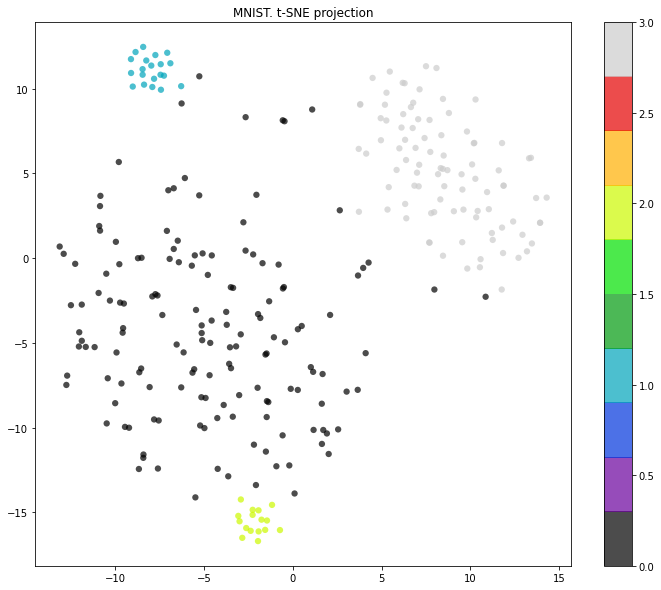

In [ ]:
tsne = TSNE(random_state=17)
X=np.vstack((embs_p,embs_p_test,embs_n,embs_b,embs_o))
y=np.zeros(embs_p.shape[0]+embs_p_test.shape[0]+embs_n.shape[0]+embs_b.shape[0]+embs_o.shape[0])
y[0:embs_p.shape[0]+embs_p_test.shape[0]]=3
y[embs_p.shape[0]+embs_p_test.shape[0]:embs_p.shape[0]+embs_p_test.shape[0]+embs_n.shape[0]]=2
y[embs_p.shape[0]+embs_p_test.shape[0]+embs_n.shape[0]:embs_p.shape[0]+embs_p_test.shape[0]+embs_n.shape[0]+embs_b.shape[0]]=1

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

На диаграмме видно, что объекты компактно сгруппированы. Несгруппированный класс - лица разных людей

#1 Исследование внутри группы p

Это объекты одного класса, которые должны быть расположены компактно и удалены от объектов других классов. В качестве метрики растояния используем l2

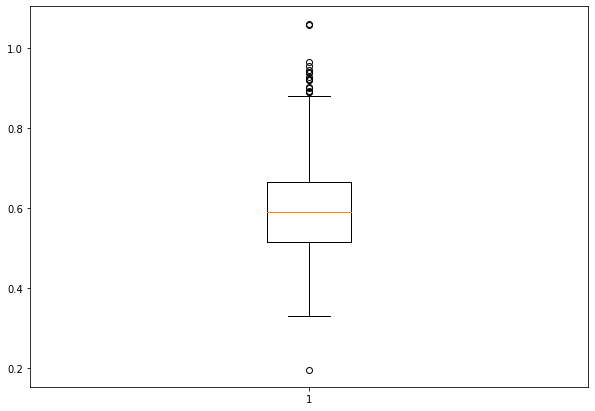

90 percentile:0.7465359387688508
95 percentile:0.8024729550726992
max l2-distance:1.0599194561825955


In [ ]:
l2s=calculate_l2(embs_p)
l2s_1d=np.zeros(int((l2s.shape[0]**2-l2s.shape[0])/2))
for i in range(l2s.shape[0]):
  start_ind=int(l2s_1d.shape[0]-(l2s.shape[0]-i)/2*(l2s.shape[0]-1-i))
  stop_ind=int((2*(l2s.shape[0]-1)-i)/2*(1+i))
  l2s_1d[start_ind:stop_ind]=l2s[i,i+1:]

fig = plt.figure(figsize =(10, 7)) 
plt.boxplot(l2s_1d)
plt.show() 
print('90 percentile:'+str(np.percentile(l2s_1d,90)))
print('95 percentile:'+str(np.percentile(l2s_1d,95)))
print('max l2-distance:'+str(np.max(l2s_1d)))

Расстояния не превышает 0.8 для 95 % изображений

#2 Посчитаем центр кластера (среднее значение) и l2 растояния до объектов

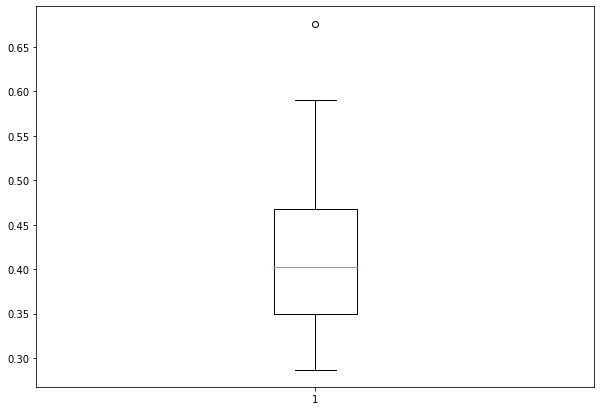

90 percentile:0.5307806690742485
95 percentile:0.557681016535316
max l2-distance:0.6762116454324842


In [ ]:
mean_p=np.mean(embs_p,axis=0)
mean_p=mean_p.reshape(1,512)
l2s=np.linalg.norm(embs_p-mean_p,axis=1)
fig = plt.figure(figsize =(10, 7)) 
plt.boxplot(l2s)
plt.show() 
print('90 percentile:'+str(np.percentile(l2s,90)))
print('95 percentile:'+str(np.percentile(l2s,95)))
print('max l2-distance:'+str(np.max(l2s)))

растояние l2 от центра кластера до 95 % объектов не превышвет 0.55

#3 Исследование класса p на тестовой выборке

Считать центр кластера и растояния до объектов на одной выборке не совсем корректно. Воспользуемся тестовой выборкой.

Тестовая выборка - 52 объекта класса p

 Посчитаем растояния от произвольного объекта p из тренировочной выборки до объектов класса p из тестовой выборки

In [ ]:
l2s=np.linalg.norm(embs_p_test-embs_p[np.random.randint(embs_p.shape[0])],axis=1)
print('90 percentile:'+str(np.percentile(l2s,90)))
print('95 percentile:'+str(np.percentile(l2s,95)))
print('max l2-distance:'+str(np.max(l2s)))

90 percentile:0.6636380546623396
95 percentile:0.7092811350408403
max l2-distance:0.7247683031047678


Для 95 % обектов l2 меньше 0.72

Посчитаем растояния от центра кластера до объектов класса p из тестовой выборки

In [ ]:
l2s=np.linalg.norm(embs_p_test-mean_p,axis=1)
print('90 percentile:'+str(np.percentile(l2s,90)))
print('95 percentile:'+str(np.percentile(l2s,95)))
print('max l2-distance:'+str(np.sort(l2s)[:-4:-1]))

90 percentile:0.5706680109894271
95 percentile:0.5874741197195037
max l2-distance:[0.68464674 0.60539395 0.60241672]


Для 95 % обектов l2 меньше 0.59

Визуализируем самые дальние объекты

p_test41.jpg
p_test15.jpg
p_test42.jpg


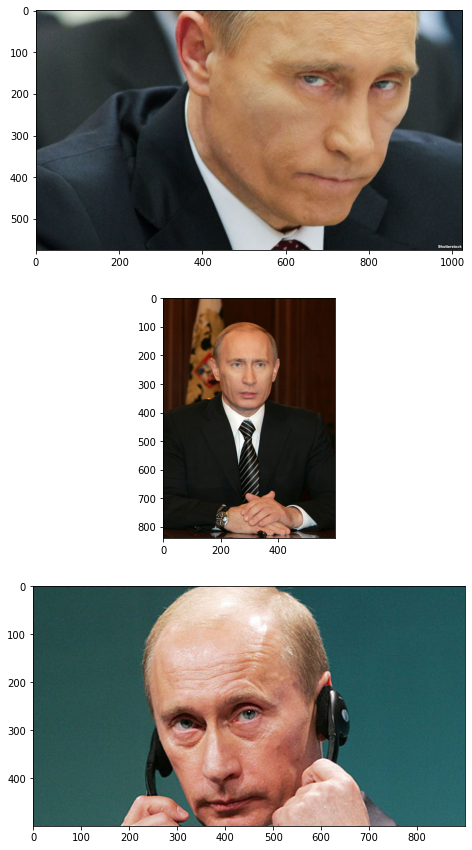

In [ ]:
fig,axes=plt.subplots(3,1,figsize=(15,15))
for i,ind in enumerate(np.argsort(l2s)[:-4:-1]):
  axes[i].imshow(Image.open('data_faces/p_test/'+file_names_p_test[ind]))
  print(file_names_p_test[ind])

Вывод:
 относительно центра кластера тестовая выборка расположена ближе, растояние до 90,95 и самого удаленного перцентиля меньше чем в случае случайного объекта кластера.
 В случае установки порога l2 0,7 относительно центра кластера  алгоритм должен показывать высокую точность принадлежности объекта к этому классу.

#4 Исследование внутри o-класса

o-класс - класс разных людей, поэтому объекты этого класса должны быть достаточно удалены друг от друга

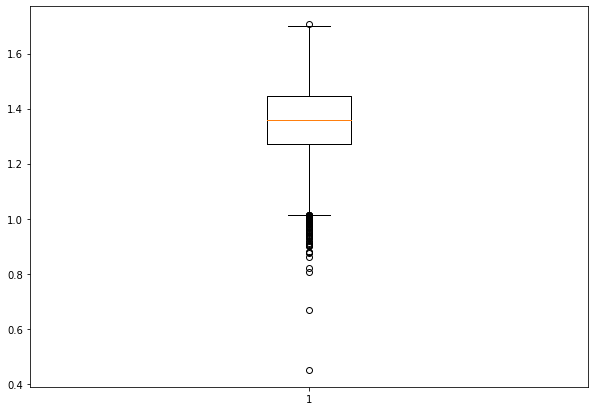

10 percentile:1.188083599237335
5 percentile:1.1375671873414046
2 percentile:1.0751637276559727
min l2-distance:[0.45137055 0.66875807 0.8064002  0.81959819 0.86043146]


In [ ]:
l2s=calculate_l2(embs_o)
l2s_1d=np.zeros(int((l2s.shape[0]**2-l2s.shape[0])/2))
for i in range(l2s.shape[0]):
  start_ind=int(l2s_1d.shape[0]-(l2s.shape[0]-i)/2*(l2s.shape[0]-1-i))
  stop_ind=int((2*(l2s.shape[0]-1)-i)/2*(1+i))
  l2s_1d[start_ind:stop_ind]=l2s[i,i+1:]

fig = plt.figure(figsize =(10, 7)) 
plt.boxplot(l2s_1d)
plt.show() 
print('10 percentile:'+str(np.percentile(l2s_1d,10)))
print('5 percentile:'+str(np.percentile(l2s_1d,5)))
print('2 percentile:'+str(np.percentile(l2s_1d,2)))
print('min l2-distance:'+str(np.sort(l2s_1d)[0:5]))

лишь между 2 % объектов расстояние меньше 1.07

Найдем объекты для трех наименьших l2

In [ ]:
check_l2(l2s,file_names_o,treshold=0.81,lower=True)

o12.jpg o23.jpg 0.4513705531470389
o45.jpg o87.jpg 0.8064001978355642
o47.jpeg o52.jpeg 0.6687580728857742


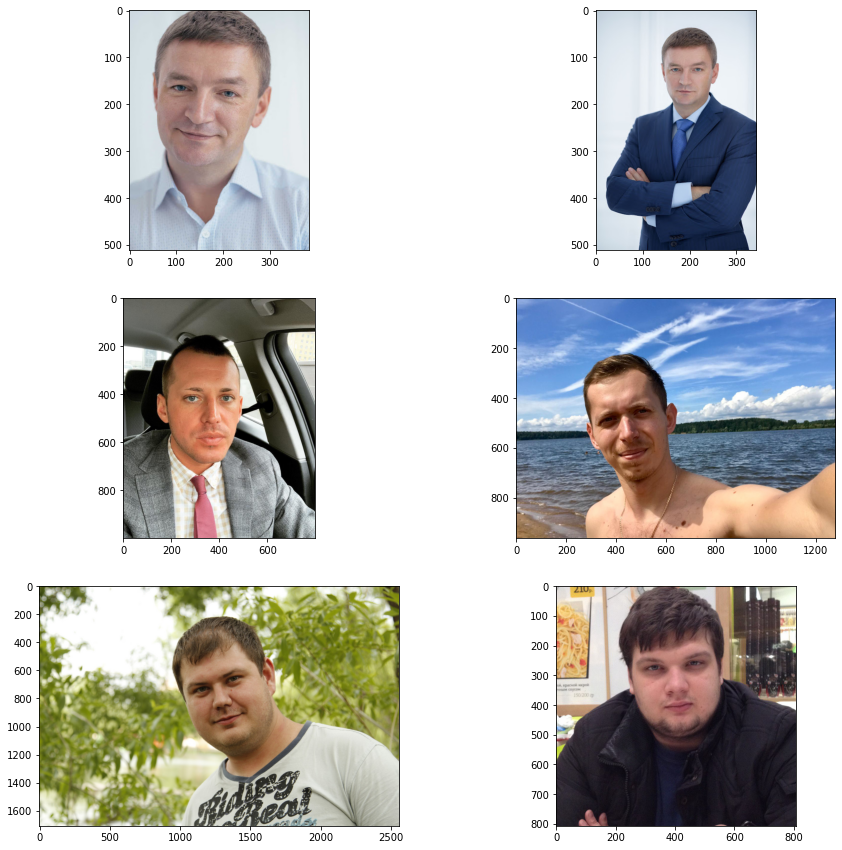

In [ ]:
f, axes = plt.subplots(3,2,figsize=(15,15))
axes[0,0].imshow(Image.open('data_faces/raw_images/o/o12.jpg'))
axes[0,1].imshow(Image.open('data_faces/raw_images/o/o23.jpg'))
axes[1,0].imshow(Image.open('data_faces/raw_images/o/o47.jpeg'))
axes[1,1].imshow(Image.open('data_faces/raw_images/o/o52.jpeg'))
axes[2,0].imshow(Image.open('data_faces/raw_images/o/o45.jpg'))
axes[2,1].imshow(Image.open('data_faces/raw_images/o/o87.jpg'))
plt.show()



В 1 случае это один и тот же человек. В случае 2 и 3 - люди очень похожи/возможно один и тот же человек.

В датасете есть повторяющиеся объекты. Необходимо очистить датасет

#5 и 6. Расстояние от o до p

Посчитаем растояние от случайного объекта из p до всех объектов o, рассмотрим перцентили

In [ ]:
l2s=np.linalg.norm(embs_o-embs_p[np.random.randint(embs_p.shape[0])],axis=1)

print('10 percentile:'+str(np.percentile(l2s,10)))
print('5 percentile:'+str(np.percentile(l2s,5)))
print('2 percentile:'+str(np.percentile(l2s,2)))
print('min l2-distance:'+str(np.min(l2s)))

10 percentile:1.213679220155308
5 percentile:1.1350171800507491
2 percentile:1.0935447387100796
min l2-distance:1.0499965964297415


Посчитаем растояние от центра p до всех объектов o, рассмотрим перцентили

In [ ]:
l2s=np.linalg.norm(embs_o-mean_p,axis=1)

print('10 percentile:'+str(np.percentile(l2s,10)))
print('5 percentile:'+str(np.percentile(l2s,5)))
print('2 percentile:'+str(np.percentile(l2s,2)))
print('min l2-distance:'+str(np.min(l2s)))

10 percentile:1.163035054544565
5 percentile:1.1249623044562282
2 percentile:1.0785127007677568
min l2-distance:0.9854545086652118


Можно сказать, что расстояние от центра p до объектов o может оказаться меньше, чем в случае  расстояния от случайного объекта из p до объектов o, но незначительно.

Ранее подобронный treshold, равный 0.7 подходит. При таком treshold ни один объект из других классов не будет распознан как объект класса p (false possitive).

# Заключение

1. В ноутбуке была рассмотрена модель facenet для распознования лиц с использованием порогового расстояния между объектами (l2-distance) для определения принадлежности классу. Между объектами одного класса l2 должно быть мало, между объектами разных классов l2 велико. Результаты это подтвердили.
2. Выяснилось, что принадлежность к классу лучше считать по расстоянию, полученному от центра кластера (посчитан та обучающей выборке) до объекта, чем от случайного объекта из обучающей выборки до объекта. На практике это значит, что нужно иметь несколько изображений одного объекта, который нужно распознавать.
3. Был подобран treshold (0.7). l2 distance внутри одного класса не превосходят этот treshold, для всех объектов других классов l2 distance выше treshold
4. Выборка является достаточно малой и о значимых результатах по ней говорить не стоит. Однако дальнейшие изучения в этом направлении по этой теме возможны